## Installation in databricks

On an existing cluster, add the following to the Advanced Options -> Spark tab:
``` 
  spark.kryoserializer.buffer.max 2000M
  spark.serializer org.apache.spark.serializer.KryoSerializer
```

In Libraries tab inside the cluster:
  * Install New -> PyPI -> spark-nlp==4.4.0 -> Install
  * Install New -> Maven -> Coordinates -> com.johnsnowlabs.nlp:spark-nlp_2.12:4.4.0 -> Install
  
Source - https://github.com/JohnSnowLabs/spark-nlp#databricks-cluster

In [26]:
import os
import sparknlp
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.linalg import VectorUDT
from pyspark.ml.linalg import Vectors
from pyspark.sql.types import ArrayType, DoubleType, IntegerType
from pyspark.sql.functions import col, udf, lit
from sparknlp.annotator import *
from sparknlp.base import *
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

In [5]:
#set properties for local machine development and databricks

# check if running in Databricks by looking for the DATABRICKS_RUNTIME_VERSION environment variable
if "DATABRICKS_RUNTIME_VERSION" in os.environ:
    # set the CSV file path for Databricks
    train_file_path = 'dbfs:/FileStore/tables/train.csv'
    aws_s3_keys = 'dbfs:/FileStore/tables/ait614_databricks_accessKeys.csv'
    s3_mount_path = '/mnt/ait614-models'
    s3_bucket_name = 'ait614-models'
else:
    # set the training file path for local machine. this training file should be placed  relative to the current notebook in data directory
    train_file_path = '/home/yarafatin/PycharmProjects/AIT-614-Final/data/train.csv'
    spark = sparknlp.start()

print('training file path {}'.format(train_file_path))

23/04/19 14:42:22 WARN Utils: Your hostname, DESKTOP-7N61Q81 resolves to a loopback address: 127.0.1.1; using 172.26.165.188 instead (on interface eth0)
23/04/19 14:42:22 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Ivy Default Cache set to: /home/yarafatin/.ivy2/cache
The jars for the packages stored in: /home/yarafatin/.ivy2/jars
com.johnsnowlabs.nlp#spark-nlp_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-02175254-d400-46fb-8c68-ee23eb32b993;1.0
	confs: [default]


:: loading settings :: url = jar:file:/home/yarafatin/softwares/anaconda3/envs/ait614/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


	found com.johnsnowlabs.nlp#spark-nlp_2.12;4.4.0 in central
	found com.typesafe#config;1.4.2 in central
	found org.rocksdb#rocksdbjni;6.29.5 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.828 in central
	found com.github.universal-automata#liblevenshtein;3.0.0 in central
	found com.google.protobuf#protobuf-java-util;3.0.0-beta-3 in central
	found com.google.protobuf#protobuf-java;3.0.0-beta-3 in central
	found com.google.code.gson#gson;2.3 in central
	found it.unimi.dsi#fastutil;7.0.12 in central
	found org.projectlombok#lombok;1.16.8 in central
	found com.google.cloud#google-cloud-storage;2.16.0 in central
	found com.google.guava#guava;31.1-jre in central
	found com.google.guava#failureaccess;1.0.1 in local-m2-cache
	found com.google.guava#listenablefuture;9999.0-empty-to-avoid-conflict-with-guava in local-m2-cache
	found com.google.errorprone#error_prone_annotations;2.16 in central
	found com.google.j2objc#j2objc-annotations;1.3 in local-m2-cache
	found com.google.http-clie

training file path /home/yarafatin/PycharmProjects/AIT-614-Final/data/train.csv


In [7]:
# Read the CSV file
schema = "qid STRING, question_text STRING, target INT"
df = spark.read \
  .option("header", "true") \
  .option("delimiter", ",") \
  .option("multiLine", "true") \
  .option("quote", "\"") \
  .option("escape", "\"") \
  .schema(schema) \
  .csv(train_file_path)

df.printSchema()
df.show(10)

root
 |-- qid: string (nullable = true)
 |-- question_text: string (nullable = true)
 |-- target: integer (nullable = true)

+--------------------+--------------------+------+
|                 qid|       question_text|target|
+--------------------+--------------------+------+
|00002165364db923c7e6|How did Quebec na...|     0|
|000032939017120e6e44|Do you have an ad...|     0|
|0000412ca6e4628ce2cf|Why does velocity...|     0|
|000042bf85aa498cd78e|How did Otto von ...|     0|
|0000455dfa3e01eae3af|Can I convert mon...|     0|
|00004f9a462a357c33be|Is Gaza slowly be...|     0|
|00005059a06ee19e11ad|Why does Quora au...|     0|
|0000559f875832745e2e|Is it crazy if I ...|     0|
|00005bd3426b2d0c8305|Is there such a t...|     0|
|00006e6928c5df60eacb|Is it just me or ...|     0|
+--------------------+--------------------+------+
only showing top 10 rows



In [8]:
#takes a long time to download, so please be patient
embeddings = WordEmbeddingsModel.pretrained("glove_840B_300", "xx") \
    .setInputCols("document", "token") \
    .setOutputCol("embeddings")

glove_840B_300 download started this may take some time.
Approximate size to download 2.3 GB
[ | ]glove_840B_300 download started this may take some time.
Approximate size to download 2.3 GB
Download done! Loading the resource.
[OK!]


In [10]:
document_assembler = DocumentAssembler().setInputCol("question_text") \
    .setOutputCol("document")

tokenizer = Tokenizer().setInputCols(["document"]) \
    .setOutputCol("token")

In [12]:
nlpPipeline = Pipeline(stages=[document_assembler,
                               tokenizer,
                               embeddings])

df = nlpPipeline.fit(df).transform(df)

In [13]:
def avg_vectors(word_vectors):
    length = len(word_vectors[0]["embeddings"])
    avg_vec = [0] * length
    for vec in word_vectors:
        for i, x in enumerate(vec["embeddings"]):
            avg_vec[i] += x
        avg_vec[i] = avg_vec[i] / length
    return avg_vec

def dense_vector(vec):
    return Vectors.dense(vec)

In [14]:
# create a udf
avg_vectors_udf = udf(avg_vectors, ArrayType(DoubleType()))
df_doc_vec = df.withColumn("doc_vector", avg_vectors_udf(col("embeddings")))
df_doc_vec.show(10)

+--------------------+--------------------+------+--------------------+--------------------+--------------------+--------------------+
|                 qid|       question_text|target|            document|               token|          embeddings|          doc_vector|
+--------------------+--------------------+------+--------------------+--------------------+--------------------+--------------------+
|00002165364db923c7e6|How did Quebec na...|     0|[{document, 0, 71...|[{token, 0, 2, Ho...|[{word_embeddings...|[0.38199613126926...|
|000032939017120e6e44|Do you have an ad...|     0|[{document, 0, 80...|[{token, 0, 1, Do...|[{word_embeddings...|[-0.7888190010562...|
|0000412ca6e4628ce2cf|Why does velocity...|     0|[{document, 0, 66...|[{token, 0, 2, Wh...|[{word_embeddings...|[0.04380194842815...|
|000042bf85aa498cd78e|How did Otto von ...|     0|[{document, 0, 56...|[{token, 0, 2, Ho...|[{word_embeddings...|[1.12683903053402...|
|0000455dfa3e01eae3af|Can I convert mon...|     0|[{doc

In [15]:
dense_vector_udf = udf(dense_vector, VectorUDT())
word_df = df_doc_vec.withColumn("features", dense_vector_udf(col("doc_vector")))

In [18]:
# split train and test data
# code inspired from https://stackoverflow.com/questions/47637760/stratified-sampling-with-pyspark
split_ratio = 0.8
seed = 42
fractions = word_df.select('target').distinct().withColumn("fraction", lit(split_ratio)) \
            .filter('fraction is not null'). rdd.collectAsMap()

train_df = word_df.stat.sampleBy('target', fractions, seed)
test_df = word_df.join(train_df, on='qid', how="left_anti")

In [19]:
lr = LogisticRegression(labelCol="target", featuresCol="features", maxIter=10, regParam=0.3, elasticNetParam=0.8)
lrModel = lr.fit(train_df)

23/04/19 14:49:28 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/04/19 14:49:28 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


In [20]:
predictions = lrModel.transform(test_df)
predictions.select("target","prediction").show(n = 10, truncate = 30)

+------+----------+
|target|prediction|
+------+----------+
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
+------+----------+
only showing top 10 rows



In [23]:
# Compute AUC-ROC
binary_evaluator = BinaryClassificationEvaluator(labelCol="target", rawPredictionCol="prediction", metricName="areaUnderROC")
auc_roc = binary_evaluator.evaluate(predictions)
print("AUC-ROC: {:.2f}%".format(auc_roc * 100))

AUC-ROC: 0.00%


In [24]:
# Compute AUC-PR
binary_evaluator = BinaryClassificationEvaluator(labelCol="target", rawPredictionCol="prediction", metricName="areaUnderPR")
auc_pr = binary_evaluator.evaluate(predictions)
print("AUC-PR: {:.2f}%".format(auc_pr * 100))

AUC-PR: 0.00%


/home/yarafatin/softwares/anaconda3/envs/ait614/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1020: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


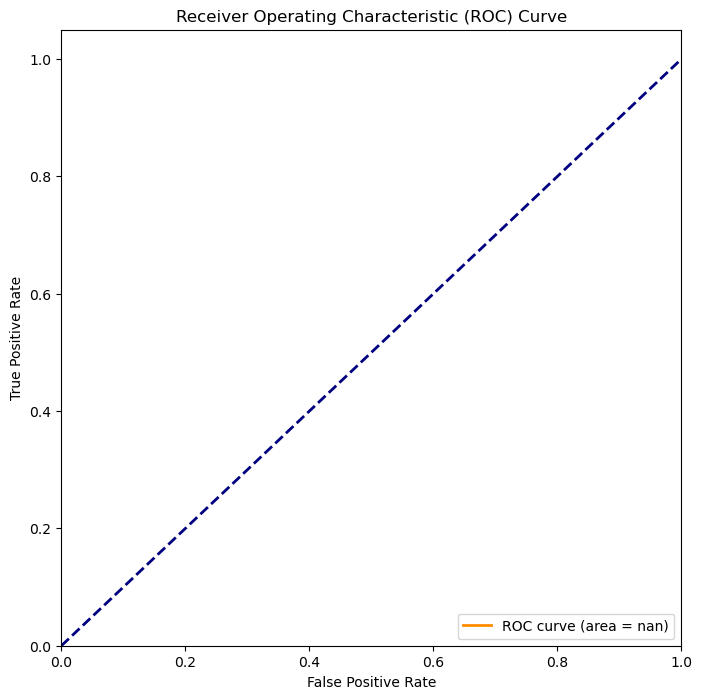

In [27]:
# Plot ROC curve
results = predictions.select(['probability', 'target']).collect()
results_list = [(float(i[0][1]), 1.0 - float(i[1])) for i in results]
fpr, tpr, _ = roc_curve([i[1] for i in results_list], [i[0] for i in results_list])
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()